## Goal: 
Propertycrime=α+Population+Population2+Murder+Robbery



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB
from sklearn import model_selection
import scipy.stats
%matplotlib inline

In [2]:
crime = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
                 )

## Clean the Data

In [3]:
#cleaning, removing header rows
crime.columns = crime.iloc[3]
crime.droprow = crime.drop(crime.index[0:4], inplace=True)

#rename columns
crime.columns = ['city','population','violent_crime','murder','rape_revised',
                 'rape_legacy','robbery','agg_assault','property_crime','burglary','larceny_theft',
                 'motor_theft','arson3']
#remove na from pop
crime.dropna(subset = ['population'], inplace=True)
#drop rape (revised def 1)
crime.drop(['rape_revised'],axis=1,inplace=True)

# Change the Arson null values to 0. 
crime['arson3'].fillna(0, inplace=True)

In [4]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 4 to 351
Data columns (total 12 columns):
city              348 non-null object
population        348 non-null object
violent_crime     348 non-null object
murder            348 non-null object
rape_legacy       348 non-null object
robbery           348 non-null object
agg_assault       348 non-null object
property_crime    348 non-null object
burglary          348 non-null object
larceny_theft     348 non-null object
motor_theft       348 non-null object
arson3            348 non-null object
dtypes: object(12)
memory usage: 35.3+ KB


In [9]:
#remove , and conver to float (for desired columns)
crime = crime.replace(',','',regex=True)
crime.iloc[:,1:] = crime.iloc[:,1:].apply(lambda x: pd.to_numeric(x))
crime = crime.reset_index(drop=True)

#giving murder and robbery indicators and creating pop ^2
crime['robbery_ind'] = crime.robbery.where(crime.robbery ==0,1)
crime['murder_ind'] = crime.murder.where(crime.murder ==0,1)
crime['pop_sq'] =crime['population'] **2

In [10]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 15 columns):
city              348 non-null object
population        348 non-null int64
violent_crime     348 non-null int64
murder            348 non-null int64
rape_legacy       348 non-null int64
robbery           348 non-null int64
agg_assault       348 non-null int64
property_crime    348 non-null int64
burglary          348 non-null int64
larceny_theft     348 non-null int64
motor_theft       348 non-null int64
arson3            348 non-null int64
robbery_ind       348 non-null int64
murder_ind        348 non-null int64
pop_sq            348 non-null int64
dtypes: int64(14), object(1)
memory usage: 40.9+ KB



## Version 1
### Propertycrime=α+Population+Population2+Murder+Robbery




I am going to start by taking ab look at the goal variables and evaluate the model. 

In [11]:
#now keeping only desired columns to answer original 
crime_reg_1 = crime.loc[:, ['property_crime','population', 'pop_sq', 'murder_ind', 'robbery_ind']]

#reset index
crime_reg_1 = crime_reg_1.reset_index(drop=True)

In [12]:
crime_reg_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 5 columns):
property_crime    348 non-null int64
population        348 non-null int64
pop_sq            348 non-null int64
murder_ind        348 non-null int64
robbery_ind       348 non-null int64
dtypes: int64(5)
memory usage: 13.7 KB


In [13]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

X = crime_reg_1[['population','pop_sq','murder_ind','robbery_ind']]
Y = crime_reg_1['property_crime']

regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))



Coefficients: 
 [  3.46570268e-02  -2.11108019e-09   1.51866535e+01  -9.62774363e+01]

Intercept: 
 -109.575335623

R-squared:
0.996124710499


We have a fairly high R2, but let's split into test and train to see if there is overfitting/what the R2 value is for the test set, when fitting on the train. 

In [14]:
data = crime_reg_1[['population','pop_sq','murder_ind','robbery_ind']]
target = crime_reg_1['property_crime']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.model_selection import train_test_split

#these data_train, etc are different than what defined above. cocneptually play different role
data_train, data_test, target_train, target_test = model_selection.train_test_split(
   data, target, test_size=0.30, random_state=42)  #train_test_split makes a random choice

# # Fit our model to the data.
regr.fit(data_train, target_train)

# Classify, storing the result in a new variable.
test_pred = regr.predict(data_test)
train_pred = regr.predict(data_train)

print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
print('The R^2 value for train set: {}',format(regr.score(data_train,target_train)))
print('The R^2 value for test set: {}',format(regr.score(data_test,target_test)))





Training Coefficients: 
 [  3.72064151e-02  -2.41386225e-09  -2.85854507e+01  -1.19355610e+02]

Training Intercept: 
 -103.825831696

Training R-squared:
The R^2 value for train set: {} 0.996831085676462
The R^2 value for test set: {} 0.570867910846872


OK. so there is clearly something off. Fitting our data off of train set is introducing some issues, likely overfitting when predicting on the test set. Lets take a look the predicted values

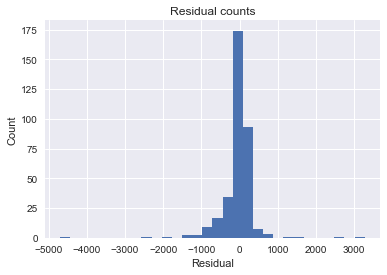

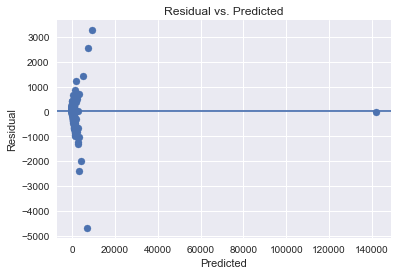

In [15]:
# Extract predicted values.
predicted = regr.predict(X)
actual = crime_reg_1['property_crime']

# Calculate residuals
residual = actual - predicted

# Histogram of residuals
plt.hist(residual,bins=30)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.xlim()
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()




ok, so there is clearly one City (New York) that constitutes an outlier
But I want to take a closer look at the points to the left

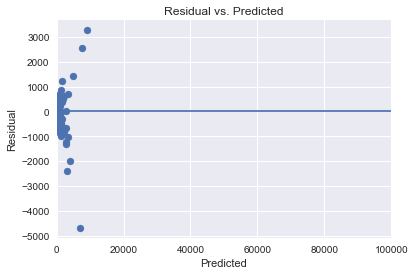

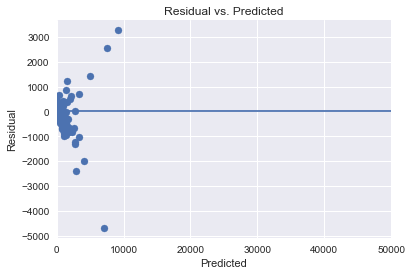

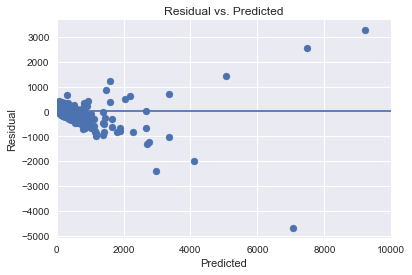

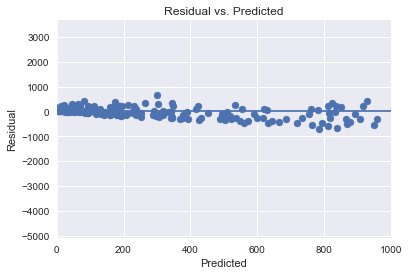

In [16]:
xlim = [(0,100000),(0,50000),(0,10000),(0,1000)]

for bounds in xlim:
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.xlim(bounds)
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()


There seems to be a pattern going on in points with lower predicted values (and less residual error). Now its time to tune the features and possibly transform them. This is evidence of  heteroscedasticity at play

### Feature engineering - V2


In [20]:
crime_2 = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
                 )

In [21]:
#I am going to go back to original data, add new indicators and winzorize my continious variables, based on the info i have.


In [22]:
#cleaning, removing header rows
crime_2.columns = crime_2.iloc[3]
crime_2.droprow = crime_2.drop(crime_2.index[0:4], inplace=True)

#rename columns
crime_2.columns = ['city','population','violent_crime','murder','rape_revised',
                 'rape_legacy','robbery','agg_assault','property_crime','burglary','larceny_theft',
                 'motor_theft','arson3']
#remove na from pop
crime_2.dropna(subset = ['population'], inplace=True)
#drop rape (revised def 1)
crime_2.drop(['rape_revised'],axis=1,inplace=True)

# Change the Arson null values to 0. 
crime_2['arson3'].fillna(0, inplace=True)

In [24]:
#remove , and conver to float (for desired columns)
crime_2 = crime_2.replace(',','',regex=True)
crime_2.iloc[:,1:] = crime_2.iloc[:,1:].apply(lambda x: pd.to_numeric(x))
crime_2 = crime_2.reset_index(drop=True)

#creating indicators
crime_2['robbery_ind'] = crime_2.robbery.where(crime_2.robbery ==0,1)
crime_2['murder_ind'] = crime_2.murder.where(crime_2.murder ==0,1)
crime_2['rape_ind'] = crime_2.rape_legacy.where(crime_2.rape_legacy ==0,1)
crime_2['assault_ind'] = crime_2.agg_assault.where(crime_2.agg_assault ==0,1)
crime_2['motor_ind'] = crime_2.motor_theft.where(crime_2.motor_theft ==0,1)


In [25]:
#now keeping only desired columns (adding larcenyt and burglary as continuous)
crime_reg_2 = crime_2.loc[:, ['property_crime','population', 'burglary','larceny_theft', 'murder_ind',
                              'robbery_ind','rape_ind','assault_ind', 'motor_ind']]

#reset index
crime_reg_2 = crime_reg_2.reset_index(drop=True)

In [26]:
crime_reg_2.describe()

,property_crime,population,burglary,larceny_theft,murder_ind,robbery_ind,rape_ind,assault_ind,motor_ind
count,348.000000,3.480000e+02,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,792.606322,4.003763e+04,119.683908,637.017241,0.140805,0.600575,0.413793,0.810345,0.732759
std,7659.724746,4.500374e+05,924.948789,6346.054451,0.348321,0.490486,0.493221,0.392593,0.443157
min,0.000000,5.260000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.500000,3.003000e+03,6.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,112.500000,7.233500e+03,17.500000,94.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,341.000000,1.842750e+04,51.250000,287.250000,0.000000,1.000000,1.000000,1.000000,1.000000
max,141971.000000,8.396126e+06,16606.000000,117931.000000,1.000000,1.000000,1.000000,1.000000,1.000000


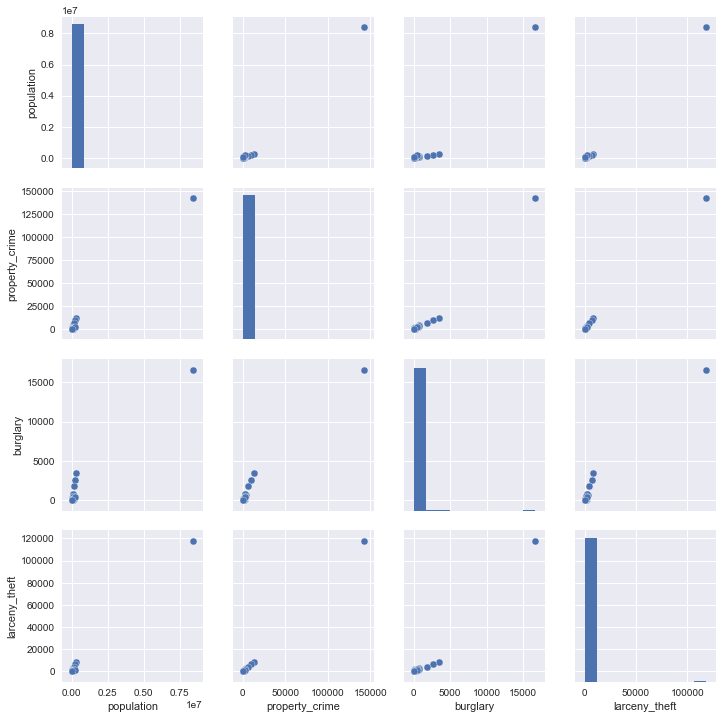

In [28]:
#pairplot, exluding the binary indicators
sns.pairplot(crime_reg_2[['population','property_crime','burglary','larceny_theft']])

In [29]:

#looking at stats and pairpolots, there are clearly extreme data points in pop and property crime
#winzorize my data, as while the values in the variables could be extreme, they could also be likely given the range in cities
#nd pops
for column in crime_reg_2.loc[:,'property_crime':'murder_ind']:
    crime_reg_2[column] = scipy.stats.mstats.winsorize(crime_reg_2[column],limits=[0.05,0.05])

In [30]:
#add pop sq now
crime_reg_2['pop_sq'] =crime_reg_2['population'] **2

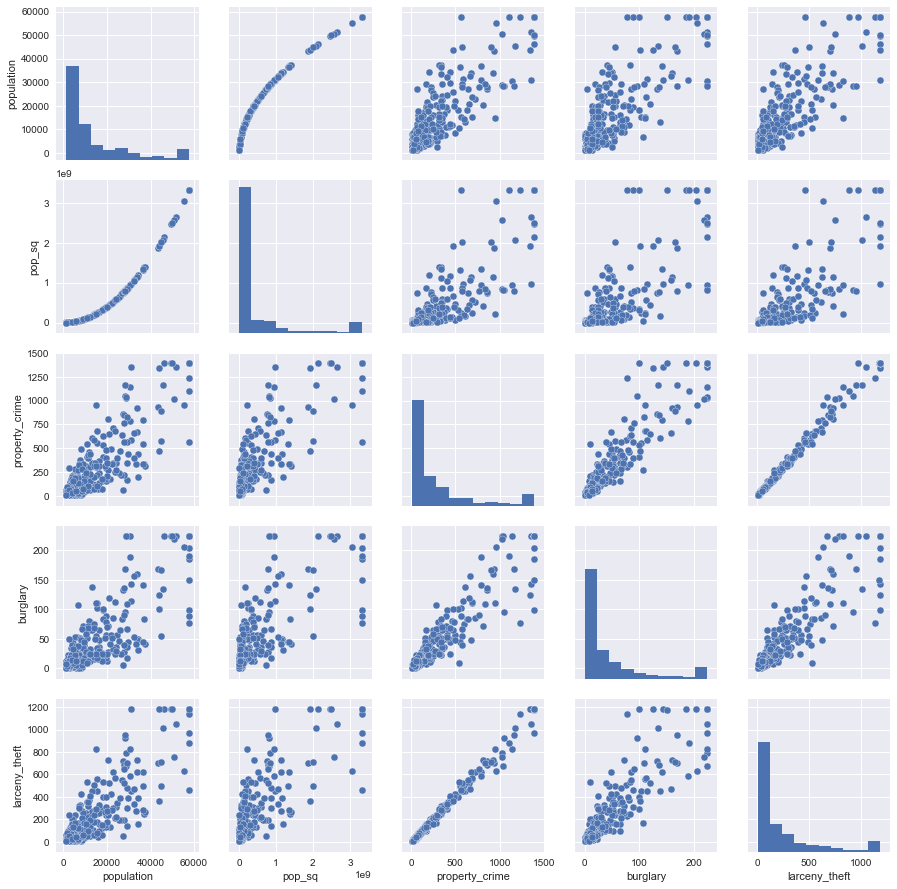

In [31]:
sns.pairplot(crime_reg_2[['population','pop_sq','property_crime','burglary','larceny_theft']])

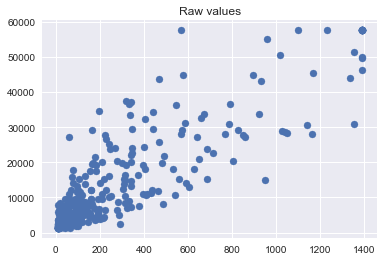

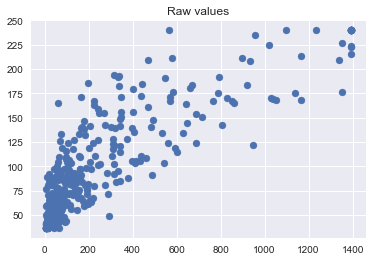

In [32]:
#is is getting easier to examine the data points now. 
#there seems to be a strong relatoiionshop between porperty crime and larceny theft. 
#Pop and pop sq do have a positive relationship with property_crime but they are not fully linnear. Let sdo some transformations

plt.scatter(crime_reg_2['property_crime'], crime_reg_2['population'])
plt.title('Raw values')
plt.show()


crime_reg_2['sqrt_pop'] = np.sqrt(crime_reg_2['population'])

plt.scatter(crime_reg_2['property_crime'], crime_reg_2['sqrt_pop'])
plt.title('Raw values')
plt.show()

In [29]:
#OK lets check the model again 

In [39]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

X = crime_reg_2[['sqrt_pop', 'pop_sq','burglary','larceny_theft', 'murder_ind',
                              'robbery_ind','rape_ind','assault_ind', 'motor_ind']]
Y = crime_reg_2['property_crime']

regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))



Coefficients: 
 [  7.25704177e-02  -1.23755519e-10   1.14835905e+00   9.83374963e-01
  -1.01994924e+00  -3.52736489e-03   1.32900637e+00  -1.40997181e+00
   1.67157968e+00]

Intercept: 
 -3.8781942816

R-squared:
0.997956957154


In [40]:
data = X
target = Y

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.model_selection import train_test_split

#these data_train, etc are different than what defined above. cocneptually play different role
data_train, data_test, target_train, target_test = model_selection.train_test_split(
   data, target, test_size=0.30, random_state=42)  #train_test_split makes a random choice
# # Fit our model to the data.
regr.fit(data_train, target_train)

# Classify, storing the result in a new variable.
test_pred = regr.predict(data_test)
train_pred = regr.predict(data_train)

print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
print('The R^2 value for train set: {}',format(regr.score(data_train,target_train)))
print('The R^2 value for test set: {}',format(regr.score(data_test,target_test)))




Training Coefficients: 
 [  8.22284225e-02  -5.51132682e-09   1.21210505e+00   9.82054860e-01
  -4.58701292e-01  -5.30683606e-01  -1.40524570e-01  -1.63254403e+00
   1.19756982e+00]

Training Intercept: 
 -4.21636803734

Training R-squared:
The R^2 value for train set: {} 0.9979237391091016
The R^2 value for test set: {} 0.9978748723315328


OK, so the R^2 of my train and test arwe very close ( and high). I should maybe be worried about overfitting. I want to check the predicted values, as well as test for multicollinearty. 

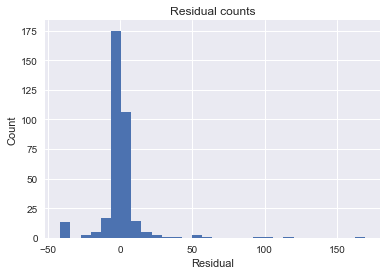

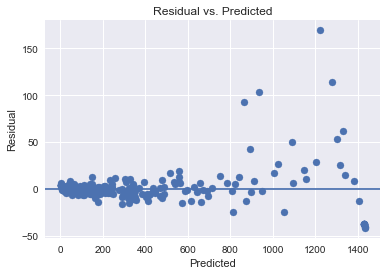

In [41]:
# Extract predicted values.
predicted = regr.predict(X)
actual = crime_reg_2['property_crime']

# Calculate residuals
residual = actual - predicted

# Histogram of residuals
plt.hist(residual,bins=30)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.xlim()
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()




In [43]:
from IPython.display import display
correlation_matrix = X.corr()
display(correlation_matrix)

,sqrt_pop,pop_sq,burglary,larceny_theft,murder_ind,robbery_ind,rape_ind,assault_ind,motor_ind
sqrt_pop,1.000000,0.870328,0.820055,0.857042,0.543158,0.554665,0.556501,0.375432,0.443680
pop_sq,0.870328,1.000000,0.830305,0.871133,0.563179,0.366363,0.437306,0.229617,0.282917
burglary,0.820055,0.830305,1.000000,0.918194,0.595177,0.476917,0.568770,0.311612,0.344758
larceny_theft,0.857042,0.871133,0.918194,1.000000,0.564809,0.497788,0.559026,0.307996,0.355001
murder_ind,0.543158,0.563179,0.595177,0.564809,1.000000,0.313271,0.381186,0.195844,0.225805
robbery_ind,0.554665,0.366363,0.476917,0.497788,0.313271,1.000000,0.470749,0.428592,0.448838
rape_ind,0.556501,0.437306,0.568770,0.559026,0.381186,0.470749,1.000000,0.302276,0.283244
assault_ind,0.375432,0.229617,0.311612,0.307996,0.195844,0.428592,0.302276,1.000000,0.403539
motor_ind,0.443680,0.282917,0.344758,0.355001,0.225805,0.448838,0.283244,0.403539,1.000000


burlgary and larceny have strong correlations with each other. I might want to think about creating a feature, combing these two variables. Same with the sqrt of pop and pop squared. 